Note:
<br/>Place your 'kaggle.json' file containing the Kaggle API token in the same folder to run the model on larger data. (If running on google colab, upload it to your session.)

# Fetch Datasets
1. Init connection with kaggle to download the required datasets.
2. Download the datasets.
3. Unzip the downloaded archives to obtain the data in csv format.



In [16]:
#Run this cell only if running the model on dataset from kaggle.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
#Run this cell only if running the model on dataset from kaggle.
!kaggle datasets download skihikingkevin/pubg-match-deaths -f aggregate/agg_match_stats_0.csv
!unzip agg_match_stats_0.csv.zip
!kaggle datasets download skihikingkevin/pubg-match-deaths -f deaths/kill_match_stats_final_0.csv
!unzip kill_match_stats_final_0.csv.zip

100% 401M/402M [00:15<00:00, 22.3MB/s]
100% 402M/402M [00:15<00:00, 26.9MB/s]
Archive:  agg_match_stats_0.csv.zip
  inflating: agg_match_stats_0.csv   
 98% 452M/460M [00:19<00:00, 23.6MB/s]
100% 460M/460M [00:19<00:00, 25.2MB/s]
Archive:  kill_match_stats_final_0.csv.zip
  inflating: kill_match_stats_final_0.csv  


# Load datasets to respective dataframes

In [1]:
import pandas as pd
import math
import numpy as np

In [18]:
#Run this cell only if running the model on dataset from kaggle.
df1 = pd.read_csv("agg_match_stats_0.csv")
df2 = pd.read_csv("kill_match_stats_final_0.csv")
ls = df1.loc[:,"match_id"].unique()
matchAggDf = df1[df1["match_id"] == ls[5]]
matchDf = df2[df2["match_id"] == ls[5]]

In [2]:
#Run this cell only if running the model on dataset from GitHub Repository.
matchAggDf = pd.read_csv("aggregate_match_data.csv")
matchDf = pd.read_csv("match_data.csv")

In [4]:
matchAggDf = matchAggDf.sort_values(by=["team_id"])
matchDf = matchDf.sort_values(by=["time"])
print(matchAggDf)
print(matchDf)


    Unnamed: 0                      date  ...  team_id team_placement
0          488  2018-01-07T03:45:01+0000  ...        2              1
1          489  2018-01-07T03:45:01+0000  ...        2              1
2          441  2018-01-07T03:45:01+0000  ...        3             10
3          442  2018-01-07T03:45:01+0000  ...        3             10
4          443  2018-01-07T03:45:01+0000  ...        4              2
..         ...                       ...  ...      ...            ...
87         485  2018-01-07T03:45:01+0000  ...       48             40
88         440  2018-01-07T03:45:01+0000  ...       49              4
89         439  2018-01-07T03:45:01+0000  ...       49              4
90         486  2018-01-07T03:45:01+0000  ...       50              3
91         487  2018-01-07T03:45:01+0000  ...       50              3

[92 rows x 16 columns]
    Unnamed: 0  killed_by  ... victim_position_x  victim_position_y
0            8       S686  ...          370761.1           423662.1


## Obtain the time-series of combats by sorting the data by time.

In [5]:
sortedDf = matchDf.sort_values(by=["time"])
sortedDf

,Unnamed: 0,killed_by,killer_name,killer_placement,killer_position_x,killer_position_y,map,match_id,time,victim_name,victim_placement,victim_position_x,victim_position_y
0,8,S686,Jingchita,40.0,370990.6,424074.5,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,89,OmGiTzPauly,47.0,370761.1,423662.1
1,45,S686,Ascholes,43.0,367649.3,421192.5,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,96,NorthernGriz,46.0,368288.5,421208.9
2,19,S12K,Bookinga,44.0,371186.5,423791.3,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,97,BergerBoi,47.0,371092.2,423650.7
3,58,Micro UZI,NoParkingHere,30.0,366649.1,424968.1,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,102,Dszs,44.0,366968.4,425042.9
4,2,S686,Ascholes,43.0,366921.4,421623.9,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,103,CtrlZee,46.0,367304.5,421216.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,84,M416,JoyFeng-,3.0,571932.8,299159.9,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,1628,98888888kK,7.0,567754.1,290418.5
86,76,Bluezone,NaN,NaN,NaN,NaN,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,1646,zd1994925,7.0,0.0,0.0
87,87,M416,DouYuTV-SeaL,1.0,566927.6,290606.1,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,1905,JoyFeng-,3.0,568948.1,293965.7
88,55,Grenade,MeLeeXH,1.0,568047.1,288962.2,MIRAMAR,2U4GBNA0YmnLSqvEycnTjo-KT000vfUnhSA2vfVhVPe1QB...,1944,LowGe,3.0,567814.8,294379.8


## Simulate match to generate time-series of trust values of players on basis of combat data

In [6]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

trustFactorTable = {}
def normalizeTime(x, sortedDf):
  min = sortedDf["time"].iloc[0]
  max = sortedDf["time"].iloc[-1]
  diff = max - min
  return ((x - min)/diff)
  
sortedDf = matchDf.sort_values(by=["time"])
trustFactorTable["timestep"] = [0]
for i in sortedDf.iloc[-1:].loc[:, "killer_name"].unique():
  trustFactorTable[i] = [0]
for i in matchDf.loc[:, "victim_name"].unique():
  trustFactorTable[i] = [0]

trustFactorDf = pd.DataFrame(trustFactorTable)

def insertDataToCurrentTimestep(x, newVal, time):
  tempDfArr = []
  tempDfArr.append(time)
  # killer's team's trust factor update:
  team = []
  team_id = 0
  for i in matchAggDf.index:
    if matchAggDf["player_name"][i] == x:
      team_id = matchAggDf["team_id"][i]
  for i in matchAggDf.index:
    if matchAggDf["team_id"][i] == team_id:
      team.append(matchAggDf["player_name"][i])
  # killer's trust factor update:
  for i in trustFactorDf:
    if i == "timestep":
      continue
    elif i not in team:
      tempDfArr.append((trustFactorDf.iloc[-1][i]))
    else:
      tempDfArr.append(sigmoid(trustFactorDf.iloc[-1][i] + newVal))
  
  trustFactorDf.loc[len(trustFactorDf.index)] = tempDfArr
  

for i in sortedDf.index:
  if sortedDf['killer_name'][i] in trustFactorTable:
    if trustFactorDf.iloc[-1][sortedDf['victim_name'][i]] >= 0.5:
      total_trust = (-1)*(0.5*normalizeTime(sortedDf['time'][i], sortedDf) + 0.5*(trustFactorDf.iloc[-1][sortedDf['victim_name'][i]] - 0.5))
      insertDataToCurrentTimestep(sortedDf['killer_name'][i], total_trust, sortedDf["time"][i])
    else:
      total_trust = (0.5*normalizeTime(sortedDf['time'][i], sortedDf) + 0.5*(0.5 - trustFactorDf.iloc[-1][sortedDf['victim_name'][i]]))
      insertDataToCurrentTimestep(sortedDf['killer_name'][i], total_trust, sortedDf["time"][i])

trustFactorDf = trustFactorDf.set_index("timestep")

display(trustFactorDf)


#Legacy Code - Uses Dict
#
# def copyPreviousDataToCurrentTimestamp(x):
#   for i in trustFactorTable:
#     if i != x:
#       trustFactorTable[i].append(trustFactorTable[i][-1])
#
# for i in sortedDf.index:
#   if sortedDf['killer_name'][i] in trustFactorTable:
#     if trustFactorTable[sortedDf['victim_name'][i]][-1] >= 0.5:
#       trustFactorTable[sortedDf['killer_name'][i]].append(trustFactorTable[sortedDf['killer_name'][i]][-1] - normalise(sortedDf['time'][i]))
#     else:
#       trustFactorTable[sortedDf['killer_name'][i]].append(trustFactorTable[sortedDf['killer_name'][i]][-1] + normalise(sortedDf['time'][i]))
#     copyPreviousDataToCurrentTimestamp(sortedDf['killer_name'][i])
#
#
# for i in trustFactorTable:
#   print(len(trustFactorTable[i]), " | ", trustFactorTable[i], " | ", i)

,DouYuTV-SeaL,OmGiTzPauly,NorthernGriz,BergerBoi,Dszs,CtrlZee,SADEX,1000level,Bookinga,BigBeefyy,MoNKeY203tG,Ascholes,PurplePenguin9,34DTrueDamage,dinkeing,ImSoPhamcy,Ninjakirby,Sichuanxlg,Jingchita,AbelZz,xXtentacionXx,BNOISE,patrickmoneyy,heavychevyz7197,KCannon98,lzuizhengui0818,xiaogao13,Haten-Gu,Newblacen,Unity_Yi,WellSuited,HKR-iNexxT,A_Araujo,X3evolution,NoParkingHere,Sugar_Booger423,nide2Bxiaojiejie,Northidaho,zhuyi1993,ZZTYSR,...,FreshMelonBalls,NET_MANHDUNG2,Games_414_TQ1,LittleMoustache,SuccMeOffSki,Daerljgodi,SAOZISHUIZHENDUO,Corleone_Wu,LuToRious,chenpan007,Pis22,KrazyPortuguese,xuezhiqian717,WOJIAOLIGUAPI,Dinostoned,JoeyJoeman,UrGrandFather,Piece_of_Sht,Hcl211,BlackDpre,Vjolt,pdfjkkvjk,DjmikeC25,BuckFutt22,Summertime333,TONGLIANGZHI,Solayuki1,Weirdo7777,NameLessisME,ZachOnTitan,Reesman22,FantasticBoys,Kroy2005,IdiotWHJ,EnGliSh22,98888888kK,zd1994925,JoyFeng-,LowGe,TedHQW
timestep,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
89.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.562177,0.562177,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
96.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.562635,0.562635,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.562177,0.562177,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
97.0,0.000000,0.0,0.0,0.0,0.562701,0.0,0.0,0.0,0.562701,0.0,0.562635,0.562635,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.562177,0.562177,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
102.0,0.000000,0.0,0.0,0.0,0.562701,0.0,0.0,0.0,0.562701,0.0,0.562635,0.562635,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.562177,0.562177,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.491298,0.000000,0.00000,0.491298,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Processing the trust values.
* Generate histogram for each timestep 
* Compute 0.5 quantile of each histogram.
* Obtain a time-series of quantiles.

0.0  -  0.0
89.0  -  0.0
96.0  -  0.0
97.0  -  0.0
102.0  -  0.0
103.0  -  0.0
105.0  -  0.0
111.0  -  0.0
113.0  -  0.0
117.0  -  0.0
123.0  -  0.0
125.0  -  0.0
126.0  -  0.0
127.0  -  0.0
131.0  -  0.0
134.0  -  0.0
137.0  -  0.0
139.0  -  0.0
144.0  -  0.0
158.0  -  0.0
163.0  -  0.0
164.0  -  0.0
165.0  -  0.0
167.0  -  0.0
170.0  -  0.0
175.0  -  0.0
183.0  -  0.0
194.0  -  0.0
199.0  -  0.0
211.0  -  0.0
215.0  -  0.0
229.0  -  0.0
232.0  -  0.0
235.0  -  0.0
248.0  -  0.0
256.0  -  0.0
357.0  -  0.0
361.0  -  0.0
368.0  -  0.0
406.0  -  0.0
411.0  -  0.0
443.0  -  0.0
552.0  -  0.0
553.0  -  0.0
565.0  -  0.0
610.0  -  0.4705641302238042
612.0  -  0.4705641302238042
642.0  -  0.4705641302238042
644.0  -  0.4705641302238042
654.0  -  0.4705641302238042
749.0  -  0.4705641302238042
751.0  -  0.4705641302238042
823.0  -  0.4882560989027184
883.0  -  0.4882560989027184
886.0  -  0.4882560989027184
935.0  -  0.4882560989027184
986.0  -  0.4882560989027184
1010.0  -  0.48825609890271

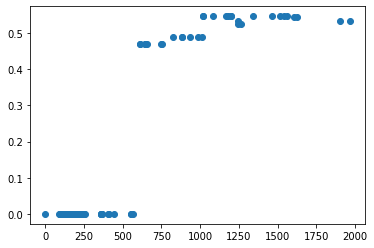

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

quantile_time_series = {}
timesteps = []
quantiles = []
for i in trustFactorDf.quantile(.5, axis="columns"):
  quantiles.append(i)
for i in trustFactorDf.index:
  timesteps.append(i)
for i in range(0, len(timesteps)):
  quantile_time_series[timesteps[i]] = quantiles[i]

for i in (quantile_time_series):
  print(i, " - ", quantile_time_series[i])

fig, ax = plt.subplots()
ax.scatter(timesteps, quantiles)


# Find time from time-series of quantiles for protagonistic-type setup
(Finding time when 50% quantile rises above the threshold for the first time)

In [8]:
for i in range(0, len(quantiles)):
  if(quantiles[i] > 0.5):
    print(timesteps[i])
    break

1018.0


#Predicting time from time-series of quantiles for antagonistic-type setup
(To predict the timestep when 50% quantile falls below threshold for the second time)
`(Keras)`

## Cleaning and reshaping data

In [9]:
for i in range(0, len(timesteps)):
  timesteps[i] = math.trunc(timesteps[i])
print(timesteps)
print(len(timesteps))
print(quantiles)

[0, 89, 96, 97, 102, 103, 103, 103, 105, 111, 113, 117, 123, 125, 126, 127, 127, 131, 134, 134, 134, 137, 139, 144, 158, 163, 164, 165, 167, 167, 170, 175, 183, 194, 199, 211, 215, 229, 232, 232, 235, 248, 256, 357, 357, 361, 361, 368, 368, 406, 411, 443, 552, 553, 565, 610, 612, 642, 644, 654, 749, 751, 823, 883, 886, 935, 986, 1010, 1018, 1018, 1083, 1168, 1181, 1201, 1201, 1244, 1244, 1263, 1339, 1467, 1518, 1539, 1560, 1609, 1628, 1905, 1966]
87
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4705641302238042, 0.4705641302238042, 0.4705641302238042, 0.4705641302238042, 0.4705641302238042, 0.4705641302238042, 0.4705641302238042, 0.4882560989027184, 0.4882560989027184, 0.4882560989027184, 0.4882560989027184, 0.4882560989027184, 0.4882560989027184, 0.54662259

In [10]:
import numpy as np
n_steps = 5
def splitSequence(seq, n_steps): 
    #Declare X and y as empty list
    X = []
    y = []
    
    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps
        
        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break
            
        #Create input and output sequence
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]
        
        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)
        pass
    #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X,y 

In [11]:
X, Y = splitSequence(quantiles, n_steps)
T, T_next = splitSequence(timesteps, n_steps)
# for i in range(0, len(X)):
#   print(X[i], " - ", Y[i])

In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
T = T.reshape((T.shape[0], T.shape[1], n_features))
# print(X)
# print(T)


## Building and training the models 



In [13]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# quantileModel = tf.keras.Sequential()
# quantileModel.add(layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# quantileModel.add(layers.Dense(1))
# print(quantileModel.layers)
# quantileModel.summary()
# quantileModel.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

# Quantile Model
from keras.models import Sequential
from keras.layers import LSTM, Dense

quantileModel = Sequential()
quantileModel.add(
    LSTM(10,
        activation='relu',
        input_shape=(5,1))
)
quantileModel.add(Dense(5))
quantileModel.add(Dense(1))
quantileModel.compile(optimizer='adam', loss='mse')

num_epochs = 25
quantileModel.fit(X, Y, epochs=num_epochs, verbose=1)
quantileModel.summary()

#Time Model

timeModel = Sequential()
timeModel.add(
    LSTM(10,
        activation='relu',
        input_shape=(5,1))
)
timeModel.add(Dense(5))
timeModel.add(Dense(1))
timeModel.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

num_epochs = 200
timeModel.fit(T, T_next, epochs=num_epochs, verbose=1)
timeModel.summary()

Epoch 1/25
3/3 [==============================] - 1s 6ms/step - loss: 0.1021
Epoch 2/25
3/3 [==============================] - 0s 7ms/step - loss: 0.0931
Epoch 3/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0841
Epoch 4/25
3/3 [==============================] - 0s 6ms/step - loss: 0.0769
Epoch 5/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0700
Epoch 6/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0631
Epoch 7/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0577
Epoch 8/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0526
Epoch 9/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 10/25
3/3 [==============================] - 0s 5ms/step - loss: 0.0435
Epoch 11/25
3/3 [==============================] - 0s 6ms/step - loss: 0.0398
Epoch 12/25
3/3 [==============================] - 0s 9ms/step - loss: 0.0371
Epoch 13/25
3/3 [==============================] - 0s 5ms/step - loss: 0.

# Testing

In [14]:
alpha = 0.5339179460170294
test_quantile_data = np.array([0.5466225937122102, 0.5456399356470478, 0.5456399356470478, 0.5339179460170294])
it = 0

#Count iterations till trust factor drops below 0.5
while(alpha > 0.5):
  test_quantile_data = np.append(test_quantile_data, [alpha])
  test_quantile_data = test_quantile_data.reshape((1, n_steps, n_features))
  predictNextNumber = quantileModel.predict(test_quantile_data, verbose=1)
  alpha = predictNextNumber
  elementIndex = np.where(test_quantile_data == test_quantile_data[0])[0][0]
  test_quantile_data = np.delete(test_quantile_data, elementIndex)
  it += 1

#Use number of iterations to predict time corresponding to point when trust factor drops below 0.5
curr_time = 1966
last_timestep = 1966
test_time_data = np.array([1539, 1560, 1609, 1628])
it_time = it
while(it_time > 0 or curr_time < last_timestep):
  test_time_data = np.append(test_time_data, [curr_time])
  test_time_data = test_time_data.reshape((1, n_steps, n_features))
  predictNextTimestep = timeModel.predict(test_time_data, verbose=1)
  curr_time = predictNextTimestep
  elementIndex = np.where(test_time_data == test_time_data[0])[0][0]
  test_time_data = np.delete(test_time_data, elementIndex)
  it_time -= 1

print("Time when trust factor of 51% players drops below 0.5:")
print(curr_time, " - ", alpha)

1/1 [==============================] - 0s 165ms/step
Time when trust factor of 51% players drops below 0.5:
[[1991.9246]]  -  [[0.4375963]]


# Accuracy Calculation

In [15]:
alpha = 0.4882560989027184
test_quantile_data = np.array([0.4882560989027184, 0.4882560989027184, 0.4882560989027184, 0.4882560989027184])
expected_next_quantile = 0.5466225937122102
it = 0

#Count iterations till trust factor drops below 0.5
while(alpha > 0.5):
  test_quantile_data = np.append(test_quantile_data, [alpha])
  test_quantile_data = test_quantile_data.reshape((1, n_steps, n_features))
  predictNextNumber = quantileModel.predict(test_quantile_data, verbose=1)
  alpha = predictNextNumber
  elementIndex = np.where(test_quantile_data == test_quantile_data[0])[0][0]
  test_quantile_data = np.delete(test_quantile_data, elementIndex)
  it += 1

#Use number of iterations to predict time when trust factor drops below 0.5
curr_time = 1010
last_timestep = 1010
test_time_data = np.array([883, 886, 935, 986])
expected_next_timestep = 1018
it_time = it
while(it_time > 0 or curr_time < last_timestep):
  test_time_data = np.append(test_time_data, [curr_time])
  test_time_data = test_time_data.reshape((1, n_steps, n_features))
  predictNextTimestep = timeModel.predict(test_time_data, verbose=1)
  curr_time = predictNextTimestep
  elementIndex = np.where(test_time_data == test_time_data[0])[0][0]
  test_time_data = np.delete(test_time_data, elementIndex)
  it_time -= 1
# print(curr_time, " ", alpha)
print("Timestep Accuracy: ", ((curr_time)/expected_next_timestep)*100, "%")
print("Quantile Accuracy: ", ((alpha)/expected_next_quantile)*100, "%")

Timestep Accuracy:  99.21414538310412 %
Quantile Accuracy:  89.32234132271873 %
